In [20]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow import keras
from keras import models, layers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.io import imshow

1 Physical GPUs, 1 Logical GPUs


In [21]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_images_org, test_images_org = [], []
train_labels_org, test_labels_org = [], []

for label, class_name in enumerate(class_names):
    
    for i in range(0, 5000): # train set
        file = class_name + '/i0{0:04d}.jpg'.format(i+1) # 이미지 파일 이름을 만든다.
        image = imread('cifar/' + file)                # 이미지를 읽는다.
        train_images_org.append(image)
        train_labels_org.append(label)
    
    for i in range(5000, 6000): # test set
        file = class_name + '/i0{0:04d}.jpg'.format(i+1) # 이미지 파일 이름을 만든다.
        image = imread('cifar/' + file)                # 이미지를 읽는다.
        test_images_org.append(image)
        test_labels_org.append(label)

train_images_org = np.array(train_images_org)
test_images_org = np.array(test_images_org)

train_labels_org = np.array(train_labels_org)
test_labels_org = np.array(test_labels_org)

In [22]:
print("셔플 전: ", np.array(train_labels_org[:10]))

셔플 전:  [0 0 0 0 0 0 0 0 0 0]


In [23]:
import random

train_images, test_images = np.copy(train_images_org), np.copy(test_images_org)
train_labels, test_labels = np.copy(train_labels_org), np.copy(test_labels_org)

shuffle_index = []
for i in range(50000):
    shuffle_index.append(i)
    
random.shuffle(shuffle_index)

for i in range(50000):
    train_images[i] = train_images[shuffle_index[i]]
    train_labels[i] = train_labels[shuffle_index[i]]
    
shuffle_index1 = []
for i in range(10000):
    shuffle_index1.append(i)
    
random.shuffle(shuffle_index1)

for i in range(10000):
    test_images[i] = test_images[shuffle_index1[i]]
    test_labels[i] = test_labels[shuffle_index1[i]]
    
x_train, x_test = np.array(train_images), np.array(test_images)
y_train, y_test = np.array(train_labels), np.array(test_labels)

In [24]:
print("셔플 후: ", np.array(train_labels[:10]))

셔플 후:  [7 2 0 6 2 2 6 5 9 6]


In [25]:
# 데이터 크기 확인
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)
print("y_train[3]: ", y_train[3])

x_train.shape:  (50000, 32, 32, 3)
x_test.shape:  (10000, 32, 32, 3)
y_train.shape:  (50000,)
y_test.shape:  (10000,)
y_train[3]:  6


In [27]:
pre_x_train = x_train.astype('float32')
pre_x_test = x_test.astype('float32') 
pre_x_train /= 255
pre_x_test /= 255

In [28]:
##모델 학습 all batch 추가 + dropout
pre_model_all_batch = keras.models.Sequential([
    keras.layers.Conv2D(input_shape = (32,32,3), kernel_size = (3,3), padding = 'same', filters = 32),#batch 추가
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 32),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2,2)),#32->16
    
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 64),#batch 추가
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D((2,2), strides=2),#32->16
    
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 64),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2,2)),#16->8
    
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.20),
    
    keras.layers.Conv2D(kernel_size = (3,3), padding ='same', filters = 128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2,2)),
                        
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation = 'softmax'),
])

pre_model_all_batch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 32, 32, 32)       

In [29]:
checkpoint_path = "training_all_batch/cp.cpkt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

pre_model_all_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pre_model_all_batch_history = pre_model_all_batch.fit(pre_x_train, y_train, epochs=100, validation_split=0.2,batch_size=32 ,callbacks=[cp])

Epoch 1/100
1250/1250 [==============================] - 10s 7ms/step - loss: 1.4155 - accuracy: 0.5130 - val_loss: 1.4694 - val_accuracy: 0.5134

Epoch 00001: saving model to training_all_batch\cp.cpkt
Epoch 2/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0312 - accuracy: 0.6461 - val_loss: 1.0765 - val_accuracy: 0.6465

Epoch 00002: saving model to training_all_batch\cp.cpkt
Epoch 3/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8710 - accuracy: 0.7041 - val_loss: 0.8311 - val_accuracy: 0.7310

Epoch 00003: saving model to training_all_batch\cp.cpkt
Epoch 4/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7583 - accuracy: 0.7441 - val_loss: 0.7949 - val_accuracy: 0.7243

Epoch 00004: saving model to training_all_batch\cp.cpkt
Epoch 5/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6606 - accuracy: 0.7788 - val_loss: 0.5545 - val_accuracy: 0.8100

Epoch 00005: saving model to training_all_bat

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1521 - accuracy: 0.9543 - val_loss: 0.1164 - val_accuracy: 0.9685

Epoch 00041: saving model to training_all_batch\cp.cpkt
Epoch 42/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1475 - accuracy: 0.9571 - val_loss: 0.1170 - val_accuracy: 0.9678

Epoch 00042: saving model to training_all_batch\cp.cpkt
Epoch 43/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1435 - accuracy: 0.9574 - val_loss: 0.1153 - val_accuracy: 0.9670

Epoch 00043: saving model to training_all_batch\cp.cpkt
Epoch 44/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1528 - accuracy: 0.9542 - val_loss: 0.1202 - val_accuracy: 0.9672

Epoch 00044: saving model to training_all_batch\cp.cpkt
Epoch 45/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1422 - accuracy: 0.9555 - val_loss: 0.0975 - val_accuracy: 0.9724

Epoch 00045: saving model to training_all_batch\cp.cpk

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1058 - accuracy: 0.9700 - val_loss: 0.0821 - val_accuracy: 0.9805

Epoch 00081: saving model to training_all_batch\cp.cpkt
Epoch 82/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1061 - accuracy: 0.9702 - val_loss: 0.1028 - val_accuracy: 0.9694

Epoch 00082: saving model to training_all_batch\cp.cpkt
Epoch 83/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1025 - accuracy: 0.9715 - val_loss: 0.0674 - val_accuracy: 0.9841

Epoch 00083: saving model to training_all_batch\cp.cpkt
Epoch 84/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1113 - accuracy: 0.9689 - val_loss: 0.1012 - val_accuracy: 0.9750

Epoch 00084: saving model to training_all_batch\cp.cpkt
Epoch 85/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1049 - accuracy: 0.9702 - val_loss: 0.0974 - val_accuracy: 0.9760

Epoch 00085: saving model to training_all_batch\cp.cpk

In [30]:
test_loss, test_acc = pre_model_all_batch.evaluate(pre_x_test, y_test, verbose=2)
print('테스트 정확도:', test_acc)

313/313 - 1s - loss: 1.0192 - accuracy: 0.7758
테스트 정확도: 0.7757999897003174


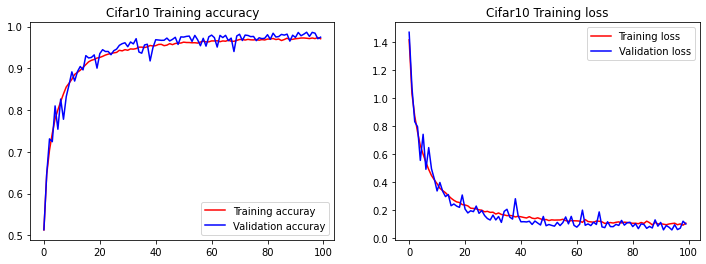

In [31]:
acc     = pre_model_all_batch_history.history['accuracy']
val_acc = pre_model_all_batch_history.history['val_accuracy']
loss    = pre_model_all_batch_history.history['loss']
val_loss = pre_model_all_batch_history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training accuray')
plt.plot(epochs, val_acc, 'b', label='Validation accuray')
plt.title("Cifar10 Training accuracy")
plt.legend(loc=0)

plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Cifar10 Training loss")
plt.legend(loc=0)
# test 정확도도 높고 loss 그래프가 안정적인 모습